In [1]:
from itertools import repeat
import random
import bisect
import networkx as nx
import numpy as np
from matplotlib import pylab
import matplotlib.pyplot as plt

In [2]:
def visualize_graph(target, nodes, min_path):
    nodes_np=np.array([np.array(n) for n in nodes])

    G = nx.from_numpy_array(nodes_np)
    G.edges(data=True)
    pos=nx.spring_layout(G)
    plt.figure(figsize=(15,11)) 
    nx.draw(G,pos,node_color='#2492ff',edge_color='#31ffaa',width=2,edge_cmap=plt.cm.Blues,with_labels=True)

    path_edges = list(zip(min_path,min_path[1:]))
    nx.draw_networkx_nodes(G,pos,nodelist=min_path, node_color='g')
    nx.draw_networkx_edges(G,pos,edgelist=path_edges, edge_color='g')
    plt.axis('equal')
    plt.show()  

### Coefficients for algorithm

- `a` and `b` - coefficients that weight the influence of the pheromone and heuristic information, respectively;
- `t_max` - maximum value of possible pheromone amounts on each trail;
- `ant_count` - count of ants;
- `p` - pheromone evaporation coefficient.

In [3]:
a = 1
b = 3
t_max = 100
ant_count = 40
p = 0.5
GRAPHS = {55: "yuzSHP55.aco", 95: "yuzSHP95.aco", 155: "yuzSHP155.aco"}

### Min-max Ant System


In [4]:
def calculate_probability(ant, number_variants, nodes, pheromones):
        variants = []
        counter = 0
        for j in range(number_variants):
            numerator = 0
            if nodes[ant[-1]][j] != 0 and (j not in ant):
                numerator = pow((pheromones[ant[-1]][j]), a) * pow(1 / (nodes[ant[-1]][j]), b)
                counter += numerator
            variants.append(numerator)
        for j in range(number_variants):
            variants[j] /= counter
            variants[j] += variants[j - 1] if j != 0 else 0
        return variants, variants[-1]

In [5]:
def min_max_ant_system(target_node):

    print(f'Graph: {GRAPHS.get(target_node)}; Source: 0, Target: {target_node}')
    with open(GRAPHS.get(target_node)) as graph_file:
        nodes = [[int(i) for i in line.split()] for line in graph_file]

    # Init pheromones
    pheromones = [[1 / target_node for i in repeat(None, target_node)] for j in repeat(None, target_node)]
    random.seed()

    for i in range(target_node):
        for j in range(target_node):
            pheromones[i][j] = 1.0 / target_node

    # Construct solution
    for j in range(t_max):
        ants = {key: [0] for key in range(ant_count)} # init ants
        flag_global = 1
        global_min_length = -1
        min_length = -1
        for i in range(ant_count):
            current_length = 0
            while ants[i][-1] != target_node - 1: # while not yet a solution
                # expand solution by one edge probabilistically according to the pheromone
                current_variants, summa = calculate_probability(ants[i], target_node, nodes, pheromones)
                random_value = random.uniform(0, summa)
                index_choice = bisect.bisect_left(current_variants, random_value)
                current_length += nodes[ants[i][-1]][index_choice]
                ants[i].append(index_choice)

            if min_length > current_length or min_length == -1:
                min_length = current_length
                min_path = list(ants[i])


            cbest = global_min_length if (flag_global and global_min_length != -1) else (min_length)

            ph_max = 1 / ((1 - p) * cbest)
            ph_min = ph_max / a

            # Global pheromone update

            for k in range(len(ants[i])):
                pheromones[ants[i][-2]][ants[i][-1]] += 1 / cbest
                if pheromones[ants[i][-2]][ants[i][-1]] < ph_min:
                    pheromones[ants[i][-2]][ants[i][-1]] = ph_min
                elif pheromones[ants[i][-2]][ants[i][-1]] > ph_max:
                    pheromones[ants[i][-2]][ants[i][-1]] = ph_max

        if global_min_length > min_length or global_min_length == -1:
            global_min_length = min_length
            global_min_path = list(min_path)


        # Evaporate pheromone
        for i in range(target_node):
            for k in range(target_node):
                pheromones[i][k] *= (1 - p)
    visualize_graph(target_node, nodes, global_min_path)
    print(f'Shortest path {global_min_path} \n Length: {global_min_length}\n\n')


Graph: yuzSHP55.aco; Source: 0, Target: 55


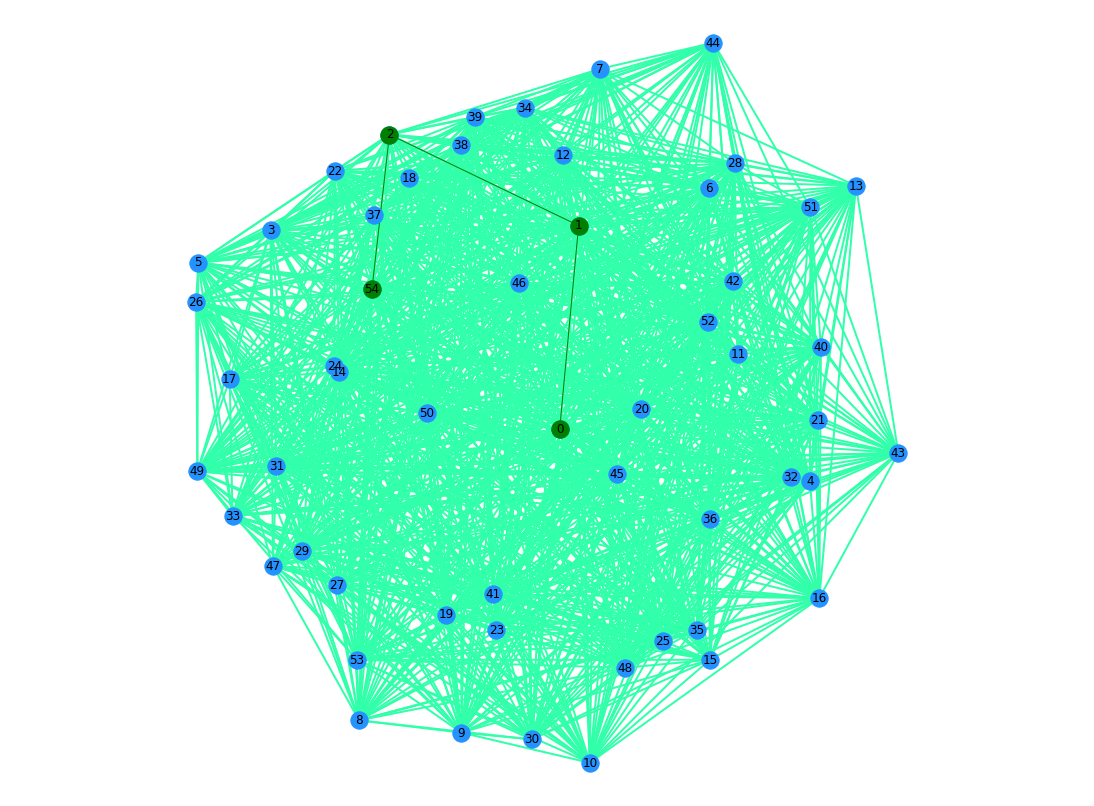

Shortest path [0, 1, 2, 54] 
 Length: 3


Graph: yuzSHP95.aco; Source: 0, Target: 95


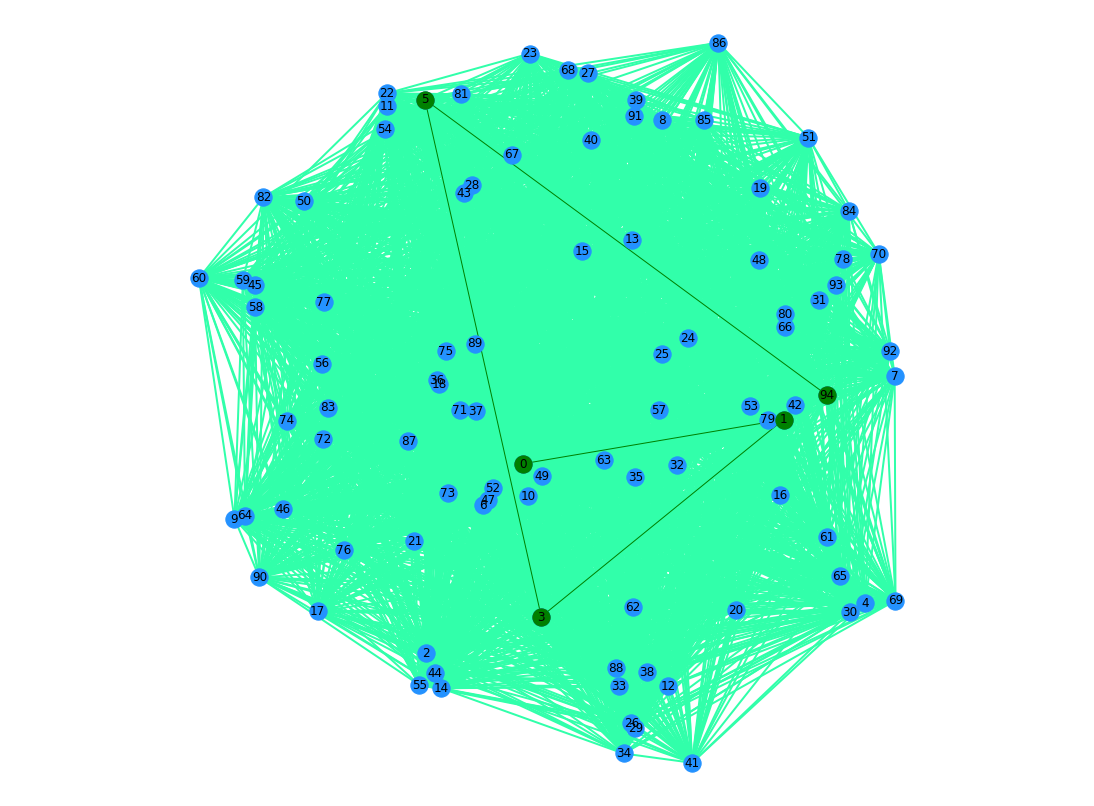

Shortest path [0, 1, 3, 5, 94] 
 Length: 12


Graph: yuzSHP155.aco; Source: 0, Target: 155


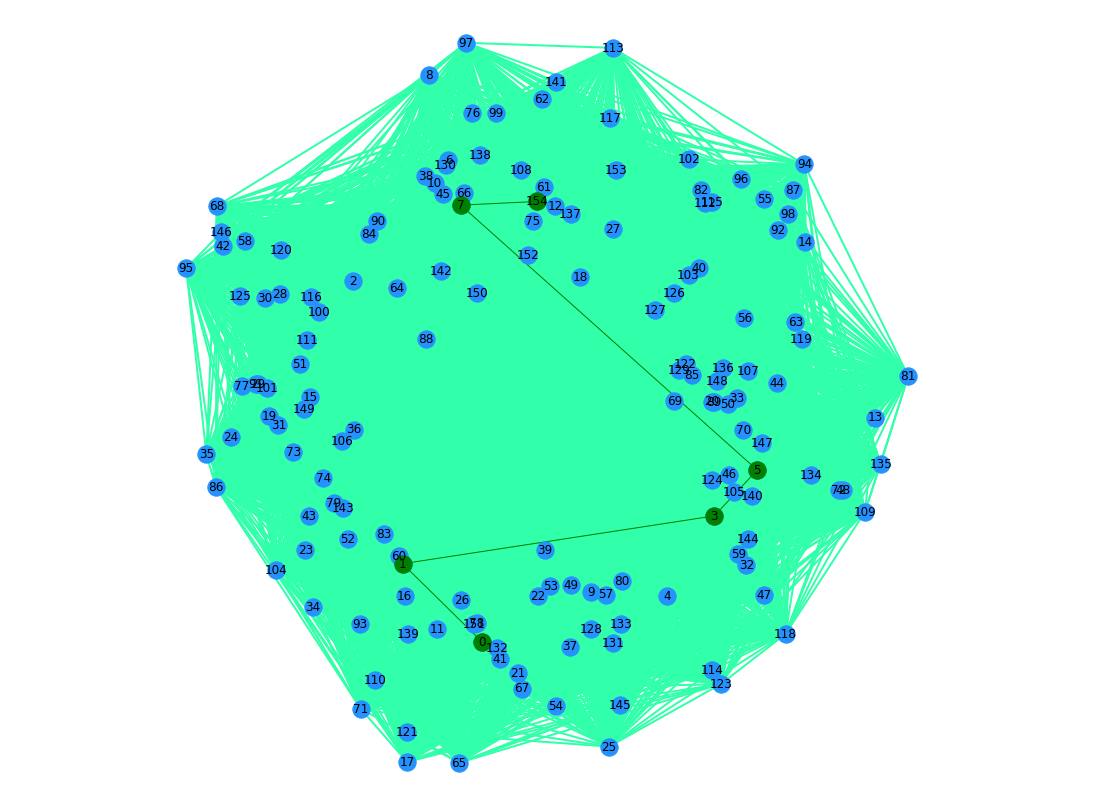

Shortest path [0, 1, 3, 5, 7, 154] 
 Length: 5




In [6]:
for target in GRAPHS:
    min_max_ant_system(target)